# TECHNICAL TEST - Data Engineer Position

- Phan Thanh Tín
- 0818355716
- thanhtin8642@gmail.com

## 1. Data Processing 

In [1]:
import pandas as pd
from datetime import datetime
from sqlalchemy import create_engine
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("./Iowa_Liquor_Sales_2017_thru_2023.csv")

In [3]:
df.head()

,Date,Store Number,Store Name,City,Category Name,Vendor Number,Vendor Name,Bottles Sold
0,01/03/2017,5230,POINT LIQUOR & TOBACCO,NaN,CANADIAN WHISKIES,260.0,DIAGEO AMERICAS,3
1,01/03/2017,4482,INDY 66 WEST #929 / INDIANOLA,NaN,AMERICAN VODKAS,434.0,LUXCO INC,6
2,01/03/2017,5359,FAREWAY STORES # 168/ PEOSTA,PEOSTA,AMERICAN VODKAS,434.0,LUXCO INC,12
3,01/03/2017,5242,KUM & GO #502 / IOWA CITY,NaN,AMERICAN VODKAS,260.0,DIAGEO AMERICAS,1
4,01/03/2017,4482,INDY 66 WEST #929 / INDIANOLA,NaN,COCKTAILS/RTD,395.0,PROXIMO,6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17468378 entries, 0 to 17468377
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Date           object 
 1   Store Number   int64  
 2   Store Name     object 
 3   City           object 
 4   Category Name  object 
 5   Vendor Number  float64
 6   Vendor Name    object 
 7   Bottles Sold   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 1.0+ GB


In [5]:
# Change all column names to lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Display the updated column names
print(df.columns)

Index(['date', 'store_number', 'store_name', 'city', 'category_name',
       'vendor_number', 'vendor_name', 'bottles_sold'],
      dtype='object')


In [6]:
# Convert date format
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

- Bottles Sold is not negative so I check for a valid value

In [7]:
invalid_bottles_sold = df[df['bottles_sold'] < 0]
invalid_bottles_sold.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4761 entries, 13610670 to 17459485
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           4761 non-null   datetime64[ns]
 1   store_number   4761 non-null   int64         
 2   store_name     4761 non-null   object        
 3   city           4761 non-null   object        
 4   category_name  4761 non-null   object        
 5   vendor_number  4761 non-null   float64       
 6   vendor_name    4761 non-null   object        
 7   bottles_sold   4761 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 334.8+ KB


In [8]:
df['bottles_sold'].describe()

count    1.746838e+07
mean     1.139259e+01
std      3.315970e+01
min     -6.480000e+02
25%      3.000000e+00
50%      6.000000e+00
75%      1.200000e+01
max      1.320000e+04
Name: bottles_sold, dtype: float64

In [9]:
# Check for missing values
df.isnull().sum()


date                 0
store_number         0
store_name           0
city             53231
category_name     8751
vendor_number        7
vendor_name          7
bottles_sold         0
dtype: int64

- Because I don't yet know the business information and requirements on the dataset, I will create a DataFrame to store error records so that I can process them later. Only load valid data into the database after handling errors.

In [10]:
# Create a DataFrame to store error logs
error_log = pd.DataFrame(columns=df.columns)


missing_values = df[df.isnull().any(axis=1)]
if not missing_values.empty:
    error_log = pd.concat([error_log, missing_values])
    df.dropna(inplace=True)

invalid_bottles_sold = df[df['bottles_sold'] < 0]
if not invalid_bottles_sold.empty:
    error_log = pd.concat([error_log, invalid_bottles_sold])
    df = df.drop(invalid_bottles_sold.index)


error_log.to_csv('data_errors.csv', index=False)

C:\Users\thanh\AppData\Local\Temp\ipykernel_8552\2382230503.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_log = pd.concat([error_log, missing_values])


In [11]:
error_log.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66714 entries, 0 to 17459485
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           66714 non-null  datetime64[ns]
 1   store_number   66714 non-null  object        
 2   store_name     66714 non-null  object        
 3   city           13483 non-null  object        
 4   category_name  57963 non-null  object        
 5   vendor_number  66707 non-null  float64       
 6   vendor_name    66707 non-null  object        
 7   bottles_sold   66714 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 4.6+ MB


In [12]:
# data information after processing
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17401664 entries, 2 to 17468377
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   store_number   int64         
 2   store_name     object        
 3   city           object        
 4   category_name  object        
 5   vendor_number  float64       
 6   vendor_name    object        
 7   bottles_sold   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 1.2+ GB


## 2. Transformation

In [13]:
# Create store_dim table
store_dim = df[['store_number', 'store_name', 'city']].drop_duplicates().reset_index(drop=True)
store_dim['store_id'] = store_dim.index + 1
store_dim['snapshot_date'] = datetime.now().date()
store_dim['last_update'] = datetime.now()

In [14]:
store_dim.head()

,store_number,store_name,city,store_id,snapshot_date,last_update
0,5359,FAREWAY STORES # 168/ PEOSTA,PEOSTA,1,2024-11-17,2024-11-17 07:45:55.094256
1,5151,IDA LIQUOR,IDA GROVE,2,2024-11-17,2024-11-17 07:45:55.094256
2,3868,WAL-MART 3630 / MARION,MARION,3,2024-11-17,2024-11-17 07:45:55.094256
3,4136,FAREWAY STORES #983 / GRIMES,GRIMES,4,2024-11-17,2024-11-17 07:45:55.094256
4,4334,FAREWAY STORES #114 / DUBUQUE,DUBUQUE,5,2024-11-17,2024-11-17 07:45:55.094256


In [15]:
# Create category_dim table
category_dim = df[['category_name']].drop_duplicates().reset_index(drop=True)
category_dim['category_id'] = category_dim.index + 1
category_dim['snapshot_date'] = datetime.now().date()
category_dim['last_update'] = datetime.now()

In [16]:
# Create vendor_dim table
vendor_dim = df[['vendor_number', 'vendor_name']].drop_duplicates().reset_index(drop=True)
vendor_dim['vendor_id'] = vendor_dim.index + 1
vendor_dim['snapshot_date'] = datetime.now().date()
vendor_dim['last_update'] = datetime.now()

In [17]:
# Create date_dim table
date_dim = df[['date']].drop_duplicates().reset_index(drop=True)
date_dim['date_id'] = date_dim.index + 1
date_dim['day'] = date_dim['date'].dt.day
date_dim['month'] = date_dim['date'].dt.month
date_dim['year'] = date_dim['date'].dt.year
date_dim['quarter'] = date_dim['date'].dt.quarter
date_dim['day_of_week'] = date_dim['date'].dt.dayofweek

In [18]:
# Create sales_fact table
sales_fact = df.merge(date_dim, on='date') \
               .merge(store_dim, on=['store_number', 'store_name', 'city']) \
               .merge(category_dim, on='category_name') \
               .merge(vendor_dim, on=['vendor_number', 'vendor_name'])
sales_fact['sales_id'] = sales_fact.index + 1
sales_fact = sales_fact[['sales_id', 'date_id', 'store_id', 'category_id', 'vendor_id', 'bottles_sold']]

In [19]:
sales_fact.head()

,sales_id,date_id,store_id,category_id,vendor_id,bottles_sold
0,1,1,1,1,1,12
1,2,1,2,2,2,12
2,3,1,1,3,3,5
3,4,1,3,4,4,12
4,5,1,4,5,5,1


 ## 3. Load into the data warehouse (SQL Server)

In [2]:
# Connection information
username = 'sa'
password = 'thanhtin'
server = 'THANHTIN\THANHTIN'
database = 'Sales'
driver = 'SQL Server Native Client 11.0'


connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}'


engine = create_engine(connection_string)

# Check the connection
try:
    with engine.connect() as connection:
        print("Connection successful!")
except Exception as e:
    print(f"Fail: {e}")

Connection successful!


- Load data into SQL Server

In [ ]:
#Load Dim Table
store_dim.to_sql('store_dim', engine, if_exists='append', index=False)
category_dim.to_sql('category_dim', engine, if_exists='append', index=False)
vendor_dim.to_sql('vendor_dim', engine, if_exists='append', index=False)
date_dim.to_sql('date_dim', engine, if_exists='append', index=False)

In [55]:
#Load Fact Table

sales_fact.to_sql('sales_fact', engine, if_exists='append', index=False)

175

##  3. Answer the questions

#### Total Bottles Sold per Year: Calculate the total number of bottles sold each year from 2017 to 2023.

In [3]:
total_bottles_sold_query = """
SELECT 
    date_dim.year, 
    SUM(Bottles_Sold) AS Total_Bottles_Sold
FROM 
    sales_fact
JOIN 
    date_dim ON sales_fact.date_id = date_dim.date_id
GROUP BY 
    date_dim.year
ORDER BY 
    date_dim.year;
"""

# Execute the query and save the results to a DataFrame
total_bottles_sold = pd.read_sql(total_bottles_sold_query, engine)
total_bottles_sold


,year,Total_Bottles_Sold
0,2017,23490079
1,2018,25382948
2,2019,26776759
3,2020,29830600
4,2021,31201269
5,2022,30422679
6,2023,31295210


C:\Users\thanh\AppData\Local\Temp\ipykernel_25212\596645628.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='Total_Bottles_Sold', data=total_bottles_sold, palette='viridis')


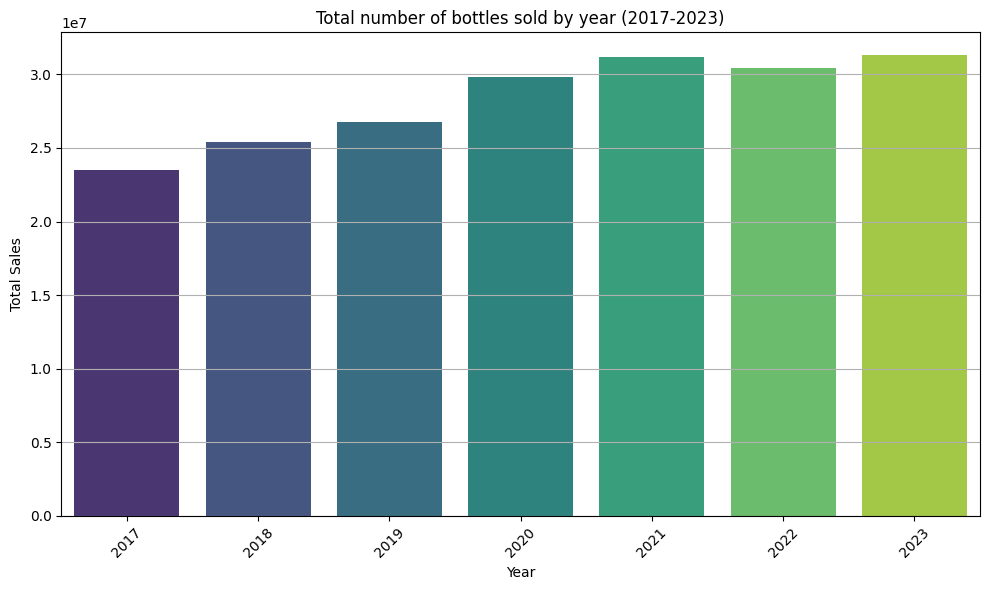

In [4]:
# Draw an illustrative diagram
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='Total_Bottles_Sold', data=total_bottles_sold, palette='viridis')
plt.title('Total number of bottles sold by year (2017-2023)')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Top 3 Vendors per City: Identify the top three vendors (Vendor Name) with the highest sales (by bottle count) in each city.

- Query by most recent record, i.e. latest snapshot_date

In [5]:
top_vendors_query = """
WITH VendorSales AS (
    SELECT 
        vendor_dim.vendor_name, 
        store_dim.city, 
        SUM(sales_fact.bottles_sold) AS Total_Bottles_Sold
    FROM 
        sales_fact
    JOIN 
        vendor_dim ON sales_fact.vendor_id = vendor_dim.vendor_id
    JOIN 
        store_dim ON sales_fact.store_id = store_dim.store_id
	WHERE 
        vendor_dim.snapshot_date IN (SELECT MAX(snapshot_date) FROM vendor_dim)
    GROUP BY 
        vendor_dim.vendor_name, store_dim.city
),
RankedVendors AS (
    SELECT 
        vendor_name, 
        city, 
        Total_Bottles_Sold,
        ROW_NUMBER() OVER (PARTITION BY city ORDER BY Total_Bottles_Sold DESC) AS Rank
    FROM 
        VendorSales
)
SELECT 
    vendor_name, 
    city, 
    Total_Bottles_Sold
FROM 
    RankedVendors
WHERE 
    Rank <= 3;

"""

top_vendors = pd.read_sql(top_vendors_query, engine)



In [6]:
top_vendors

,vendor_name,city,Total_Bottles_Sold
0,LUXCO INC,FORT ATKINSON,12388
1,DIAGEO AMERICAS,FORT ATKINSON,9612
2,LAIRD & COMPANY,FORT ATKINSON,6834
3,SAZERAC COMPANY INC,FORT DODGE,666922
4,DIAGEO AMERICAS,FORT DODGE,664182
...,...,...,...
1415,MCCORMICK DISTILLING CO.,DANVILLE,8056
1416,DIAGEO AMERICAS,DANVILLE,4904
1417,SAZERAC COMPANY INC,DAVENPORT,4603456
1418,DIAGEO AMERICAS,DAVENPORT,2575766


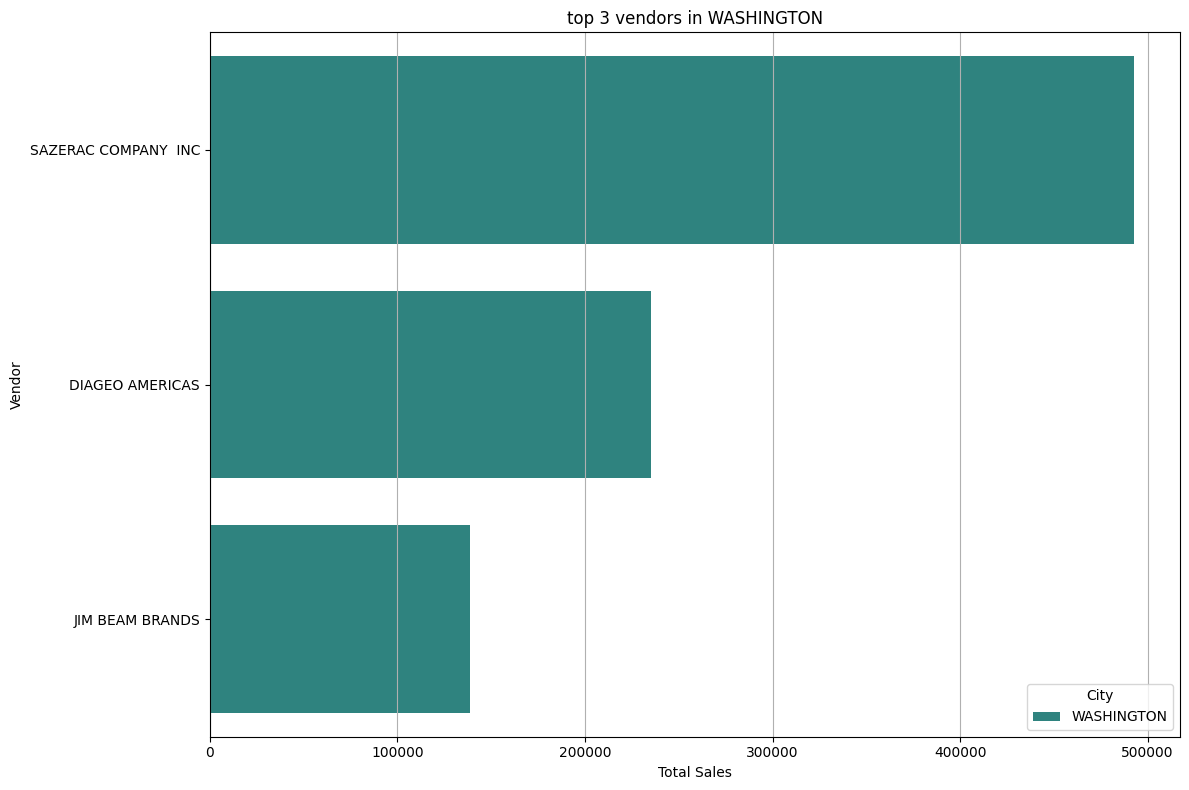

In [7]:
# Draw an illustrative chart with the top 3 vendors in WASHINGTON
top_vendors_filtered = top_vendors[top_vendors['city'].isin(['WASHINGTON'])]

plt.figure(figsize=(12, 8))
sns.barplot(x='Total_Bottles_Sold', y='vendor_name', hue='city', data=top_vendors_filtered, palette='viridis')
plt.title('top 3 vendors in WASHINGTON')
plt.xlabel('Total Sales')
plt.ylabel('Vendor')
plt.legend(title='City')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

#### Sales Analysis by Category: Analyze the sales trends for the top-selling wine categories (Category Name) year by year.

In [8]:
sales_analysis_query = """
WITH RankedData AS (
    SELECT 
        date_dim.year as Year, 
        category_dim.category_name, 
        SUM(sales_fact.bottles_sold) AS Total_Bottles_Sold,
        ROW_NUMBER() OVER (PARTITION BY date_dim.year ORDER BY SUM(sales_fact.bottles_sold) DESC) AS Rank
    FROM 
        sales_fact
    JOIN 
        date_dim ON sales_fact.date_id = date_dim.date_id
    JOIN 
        category_dim ON sales_fact.category_id = category_dim.category_id
	WHERE 
        category_dim.snapshot_date IN (SELECT MAX(snapshot_date) FROM category_dim)
    GROUP BY 
        date_dim.year, category_dim.category_name
)
SELECT 
    Year, 
    category_name, 
    Total_Bottles_Sold
FROM 
    RankedData
WHERE 
    Rank = 1;
"""

sales_analysis = pd.read_sql(sales_analysis_query, engine)

sales_analysis.head()

,Year,category_name,Total_Bottles_Sold
0,2017,AMERICAN VODKAS,5017801
1,2018,AMERICAN VODKAS,5392367
2,2019,AMERICAN VODKAS,5643365
3,2020,AMERICAN VODKAS,5937556
4,2021,AMERICAN VODKAS,6113254


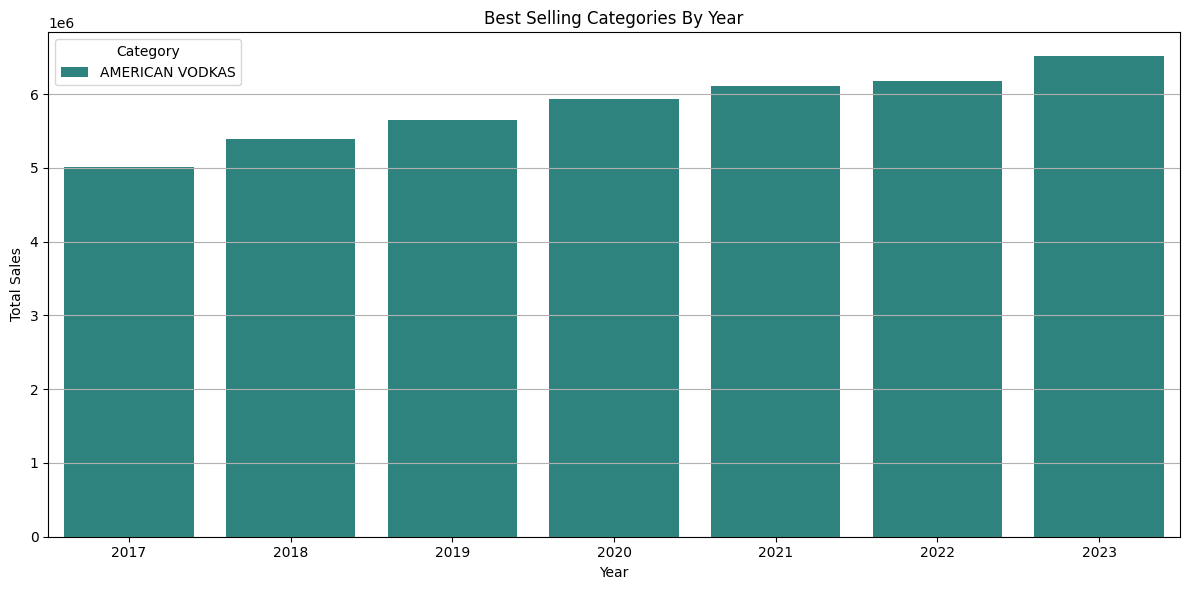

In [9]:

plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Total_Bottles_Sold', hue='category_name', data=sales_analysis, palette='viridis')
plt.title('Best Selling Categories By Year')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='Category')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Top Stores by Sales per City: Identify the stores (Store Name) with the highest wine sales in each city in the most recent year (2023).


In [13]:
top_stores_query = """
WITH RankedStores AS (
    SELECT 
        st.store_name, 
        st.city, 
        SUM(s.bottles_sold) AS Total_Bottles_Sold,
        ROW_NUMBER() OVER (
            PARTITION BY st.city 
            ORDER BY SUM(s.bottles_sold) DESC
        ) AS Rank
    FROM 
        sales_fact s
    JOIN 
        store_dim st ON s.store_id = st.store_id
    JOIN 
        date_dim d ON s.date_id = d.date_id
    WHERE 
        YEAR(d.date) = 2023 AND 
        st.snapshot_date IN (SELECT MAX(snapshot_date) FROM store_dim)
    GROUP BY 
        st.store_name, st.city
)
SELECT 
    store_name, 
    city, 
    Total_Bottles_Sold
FROM 
    RankedStores
WHERE 
    Rank = 1;
"""

top_stores = pd.read_sql(top_stores_query, engine)

top_stores.head()

,store_name,city,Total_Bottles_Sold
0,CASEY'S GENERAL STORE #1921- ACKLEY,ACKLEY,7405
1,CASEY'S GENERAL STORE #2521 / ADAIR,ADAIR,4255
2,FAREWAY STORES #124 / ADEL,ADEL,21701
3,CASEY'S GENERAL STORE #2626 / AFTON,AFTON,7389
4,AINSWORTH FOUR CORNERS / AINSWORTH,AINSWORTH,4414


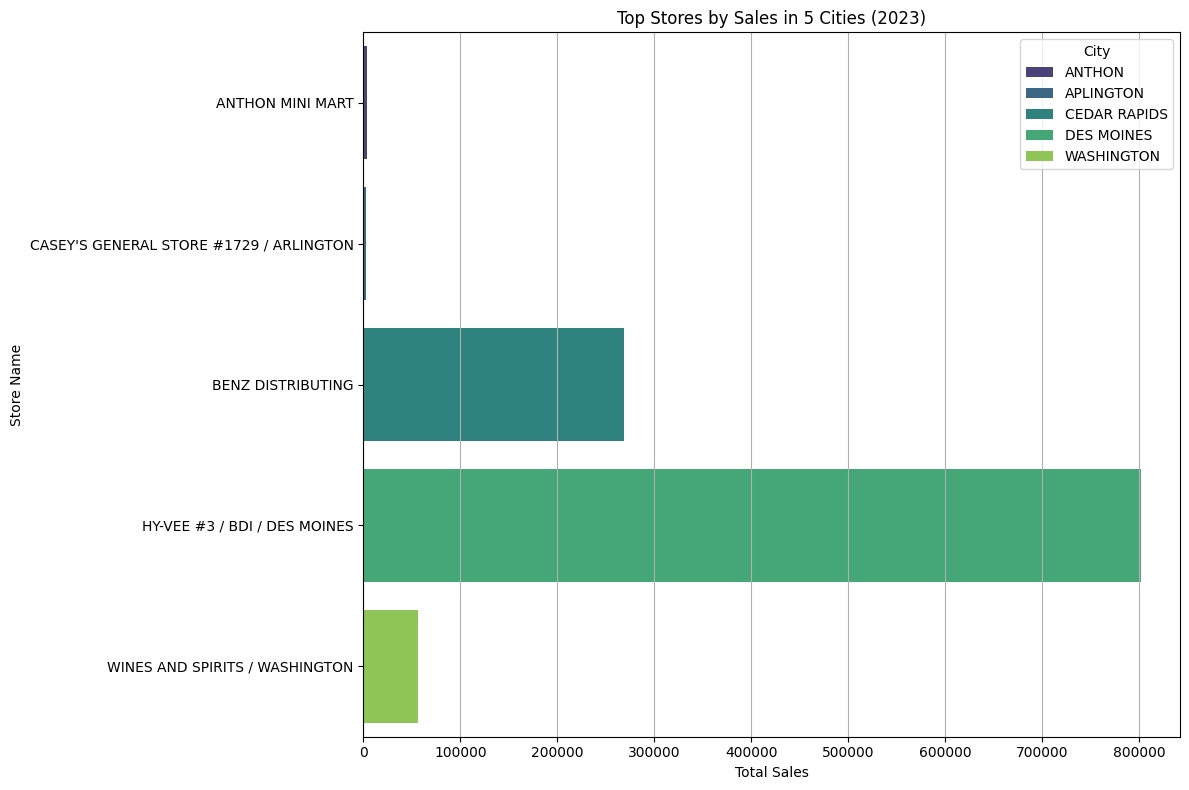

In [14]:
# Illustrative chart of best-selling products in 5 cities
selected_cities = ['ANTHON', 'APLINGTON', 'WASHINGTON', 'DES MOINES', 'CEDAR RAPIDS']
top_stores_filtered = top_stores[top_stores['city'].isin(selected_cities)]


plt.figure(figsize=(12, 8))
sns.barplot(x='Total_Bottles_Sold', y='store_name', hue='city', data=top_stores_filtered, palette='viridis')
plt.title('Top Stores by Sales in 5 Cities (2023)')
plt.xlabel('Total Sales')
plt.ylabel('Store Name')
plt.legend(title='City')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

#### Vendor Sales Share: Calculate the percentage of total sales for each vendor (Vendor Name) compared to the overall sales of all vendors across the entire time period (2017-2023).

In [15]:
vendor_sales_share_query = """
WITH TotalSales AS (
    SELECT 
        SUM(bottles_sold) AS Overall_Total_Bottles_Sold
    FROM 
        sales_fact
),
VendorSales AS (
    SELECT 
        v.vendor_name, 
        SUM(s.bottles_sold) AS Vendor_Total_Bottles_Sold
    FROM 
        sales_fact s
    JOIN 
        vendor_dim v ON s.vendor_id = v.vendor_id
    WHERE 
        v.snapshot_date IN (SELECT MAX(snapshot_date) FROM vendor_dim)
    GROUP BY 
        v.vendor_name
)
SELECT 
    vendor_name, 
    Vendor_Total_Bottles_Sold, 
    (Vendor_Total_Bottles_Sold * 100.0 / Overall_Total_Bottles_Sold) AS Sales_Share_Percentage
FROM 
    VendorSales, TotalSales
ORDER BY 
    Sales_Share_Percentage DESC;
"""

vendor_sales_share = pd.read_sql(vendor_sales_share_query, engine)

vendor_sales_share.head()

,vendor_name,Vendor_Total_Bottles_Sold,Sales_Share_Percentage
0,SAZERAC COMPANY INC,37163488,18.731640
1,DIAGEO AMERICAS,28535115,14.382652
2,LUXCO INC,14555520,7.336468
3,JIM BEAM BRANDS,13237984,6.672386
4,HEAVEN HILL BRANDS,11999663,6.048231


C:\Users\thanh\AppData\Local\Temp\ipykernel_25212\216669745.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sales_Share_Percentage', y='vendor_name', data=top_10_vendors, palette='viridis')


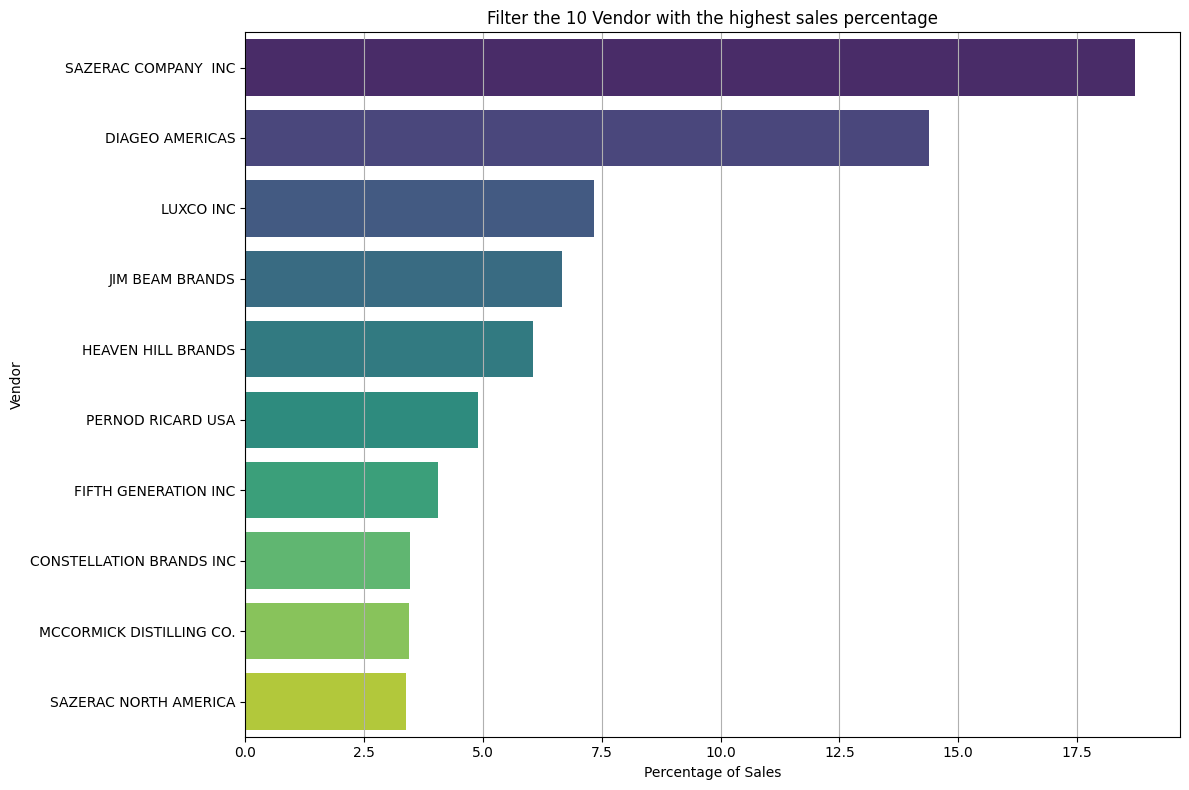

In [16]:
# Filter the 10 Vendor with the highest sales percentage
top_10_vendors = vendor_sales_share.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='Sales_Share_Percentage', y='vendor_name', data=top_10_vendors, palette='viridis')
plt.title('Filter the 10 Vendor with the highest sales percentage')
plt.xlabel('Percentage of Sales')
plt.ylabel('Vendor')
plt.grid(axis='x')
plt.tight_layout()
plt.show()
